## Phase-space 

This code use trident to get ions and make phase space for all gas, inflow and outflow gas to find out which ion is more dominant in outflows. 

Author: Vida

In [12]:
from __future__ import print_function

import numpy as np
import yt
from yt.units import *
from yt import YTArray
import argparse
import os
import glob
import sys
from astropy.table import Table
from astropy.io import ascii
import matplotlib.pyplot as plt
import random
#from photutils import detect_threshold, detect_sources, source_properties, EllipticalAperture
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import minimize
import trident
import ast
#import emcee
import numpy.random as rn
from multiprocessing import Pool
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_refine_box import get_refine_box
from foggie.utils.get_halo_center import get_halo_center
from foggie.utils.get_proper_box_size import get_proper_box_size
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib as mpl

def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Volumes/FoggieVida/" #"/Users/vida/Documents/Work/02-Projects/02-FOGGIE/FOGGIE-data/"#
    code_base_path = "/Users/vidasaeedzadeh/Projects/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref10")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot
halo = '8508'#'5036' #
run = 'nref13c_nref9f.enhance'
snap = 'DD2509'#'RD0040'#
halo_name = 'Tempest'

foggie_dir,code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

filter='radial_velocity' # it can also be 'metallicity'

def filter_ds(box):
    '''This function filters the yt data object passed in as 'box' into inflow and outflow regions,
    based on metallicity, and returns the box filtered into these regions.'''

    if (filter=='metallicity'):
        box_inflow = box.include_below(('gas','metallicity'), 0.01, 'Zsun')
        box_outflow = box.include_above(('gas','metallicity'), 1., 'Zsun')
        box_neither = box.include_above(('gas','metallicity'), 0.01, 'Zsun')
        box_neither = box_neither.include_below(('gas','metallicity'), 1., 'Zsun')
    elif (filter=='radial_velocity'):
        box_inflow = box.include_below(('gas','radial_velocity_corrected'), -100., 'km/s')
        box_outflow = box.include_above(('gas','radial_velocity_corrected'), 100., 'km/s') # the original was 200, let's try 100
        box_neither = box.include_above(('gas','radial_velocity_corrected'), -100., 'km/s')
        box_neither = box_neither.include_below(('gas','radial_velocity_corrected'), 100., 'km/s')

    return box_inflow, box_outflow, box_neither

# Add Trident ion fields
def add_ion_fields(ds):
    trident.add_ion_fields(ds, ions=['C III', 'C IV', 'O VI', 'Si III'])#['C III','C IV','O VI','O II','O III','Ne III', 'Ne V', 'Fe II', 'Fe III'])
    return ds

In [13]:
# Load the dataset with cosmology enabled
ds, refine_box = foggie_load(snap_name, trackname, halo_c_v_name=halo_c_v_name, disk_relative=True, use_cosmology=True)
print('Finished loading')

yt : [INFO     ] 2024-11-13 14:38:29,558 Parameters: current_time              = 638.06651531954
yt : [INFO     ] 2024-11-13 14:38:29,558 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-11-13 14:38:29,559 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-11-13 14:38:29,559 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-11-13 14:38:29,559 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-11-13 14:38:29,560 Parameters: current_redshift          = 0.0021037994044062
yt : [INFO     ] 2024-11-13 14:38:29,560 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2024-11-13 14:38:29,560 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2024-11-13 14:38:29,560 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-11-13 14:38:29,560 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/FoggieVida/halo_008508/nref13c_nref9f.enhance/DD2509/DD2509
get_refine_box: using this location:        col1          col2     col3     col4     col5     col6     col7   col8
------------------ -------- -------- -------- -------- -------- -------- ----
0.0021111231691204 0.488873 0.470349 0.508524 0.490873 0.472349 0.510524   10


Parsing Hierarchy : 100%|█████████| 14472/14472 [00:00<00:00, 26892.77it/s]
yt : [INFO     ] 2024-11-13 14:38:30,268 Gathering a field list (this may take a moment.)


This halo_c_v file doesn't exist, calculating halo center...
get_halo_center: code_length code_velocity
get_halo_center: obtained the spherical region
get_halo_center: extracted the DM density
get_halo_center: we have obtained the preliminary center
got the velocities
get_halo_center: located the main halo at: [0.48985743522644043, 0.47122740745544434, 0.5095312595367432] [unyt_quantity(0.001008, 'code_velocity'), unyt_quantity(-0.00177564, 'code_velocity'), unyt_quantity(0.0011421, 'code_velocity')]


yt : [WARNING  ] 2024-11-13 14:38:38,036 The young_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2024-11-13 14:38:38,042 The young_stars3 particle filter already exists. Overriding.
yt : [WARNING  ] 2024-11-13 14:38:38,046 The young_stars8 particle filter already exists. Overriding.
yt : [WARNING  ] 2024-11-13 14:38:38,050 The old_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2024-11-13 14:38:38,054 The stars particle filter already exists. Overriding.
yt : [WARNING  ] 2024-11-13 14:38:38,062 The dm particle filter already exists. Overriding.


filtering young_stars particles...
filtering young_stars3 particles...
filtering young_stars8 particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...
using particle type  young_stars  to derive angular momentum
found angular momentum vector
Finished loading


In [14]:
#ds.field_list
#ds.derived_field_list

In [15]:
add_ion_fields(ds)

EnzoDataset: /Volumes/FoggieVida/halo_008508/nref13c_nref9f.enhance/DD2509/DD2509

In [16]:
sphere = ds.sphere(ds.halo_center_kpc, (2.*ds.refine_width, 'kpc'))
print('Filtering dataset')
box_inflow, box_outflow, box_neither = filter_ds(sphere)

Filtering dataset


In [17]:
def create_phase_space_plot(box, density_field, temperature_field, target_field, region,
                            ion_name, density_units="g/cm**3", temp_units="K", 
                            number_density_units="cm**-3", n_bins=256):
    
    # Create a 2D profile for density vs temperature with the specified target field
    profile = yt.create_profile(box, [density_field, temperature_field], fields=[target_field], 
                                weight_field=None, n_bins=(n_bins, n_bins))

    density = profile.x_bins.to(density_units).v  # Density bins
    temperature = profile.y_bins.to(temp_units).v  # Temperature bins
    number_density = profile[target_field].to(number_density_units).v  # Target field (e.g., ion number density)

    # Mask NaNs and infs in number_density
    number_density = np.ma.masked_invalid(number_density)
    # Handle zeros and NaNs for LogNorm scaling
    number_density[number_density <= 0] = np.nanmin(number_density[number_density > 0]) / 1000

    if region:
        filter_desc = f"{region}"  
    else:
        filter_desc = 'nofilter'

    
    # Create a new color map by adding white at the beginning
    base_cmap = plt.get_cmap('viridis')
    colors = base_cmap(np.linspace(0, 1, 256))
    colors[0] = [1, 1, 1, 1]  # Set the first color to white (RGBA format)
    custom_cmap = ListedColormap(colors)

    # Plotting
    plt.figure(figsize=(6.4, 4.8), facecolor='white')
    vmin = 1e-19
    vmax = 1e-6


    plt.pcolormesh(density, temperature, number_density.T, shading='auto', cmap=custom_cmap, 
                   norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))#norm=mpl.colors.LogNorm(vmin=number_density.min(), vmax=number_density.max()))#cmap='viridis'
    cbar = plt.colorbar(label=f'{ion_name} Number Density [{number_density_units}]')
    
    # Labels and scales
    plt.xlabel(f"Density [$g/cm^3$]")
    plt.ylabel(f"Temperature [{temp_units}]")
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f"{ion_name} ions in {filter_desc}")
    
    plt.tight_layout()
    
    save_path = prefix + f'PhaseSpace/{filter_desc}/'
    os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists
    plt.savefig(save_path + f'{snap}_{ion_name}_phasespace_{filter_desc}' + '.png')
    plt.show()
    plt.close()

    print(number_density.min())

C IV ('gas', 'C_p3_density') ('gas', 'temperature') ('gas', 'C_p3_number_density')
Creating phase space plot for all gas


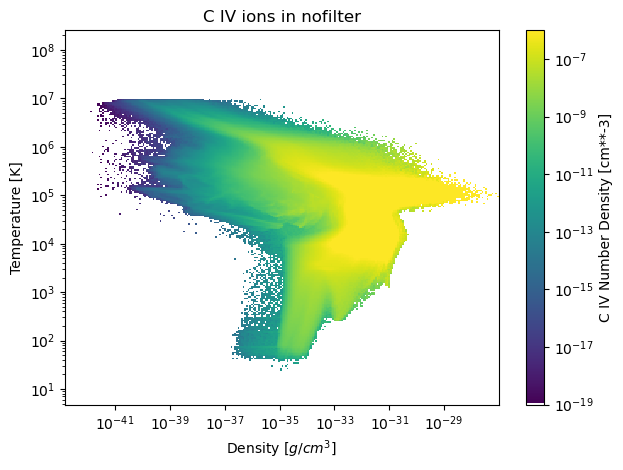

7.183456059827308e-24
Creating phase space plot for inflow


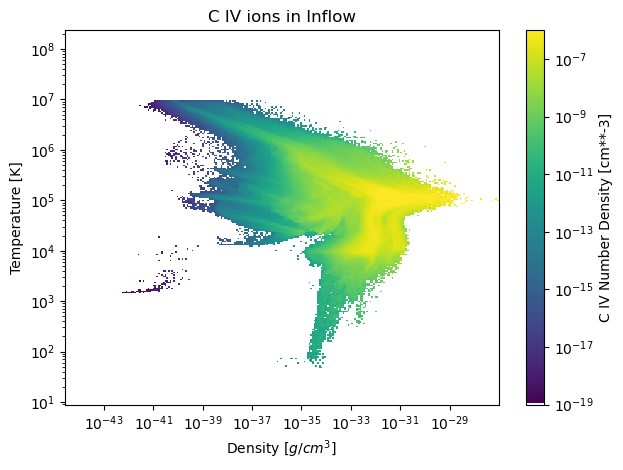

1.2697355810696733e-25
Creating phase space plot for outflow


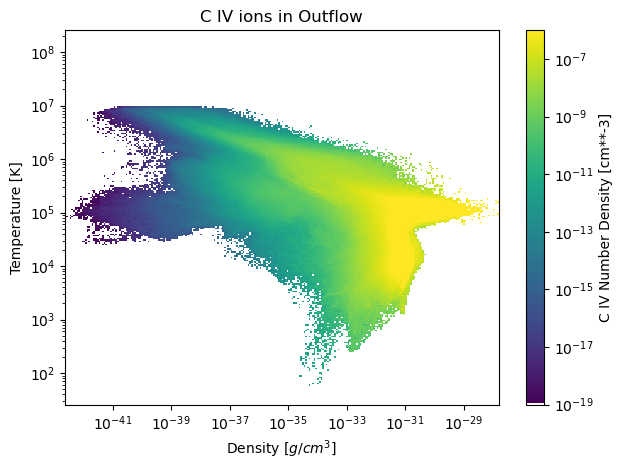

1.1527207346054407e-23
O VI ('gas', 'O_p5_density') ('gas', 'temperature') ('gas', 'O_p5_number_density')
Creating phase space plot for all gas


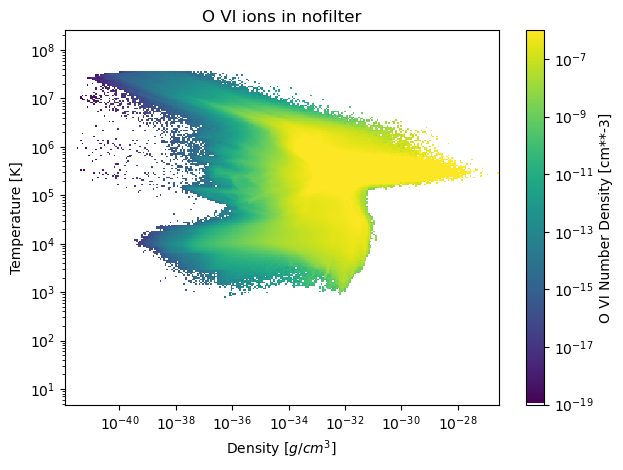

4.265866594574565e-23
Creating phase space plot for inflow


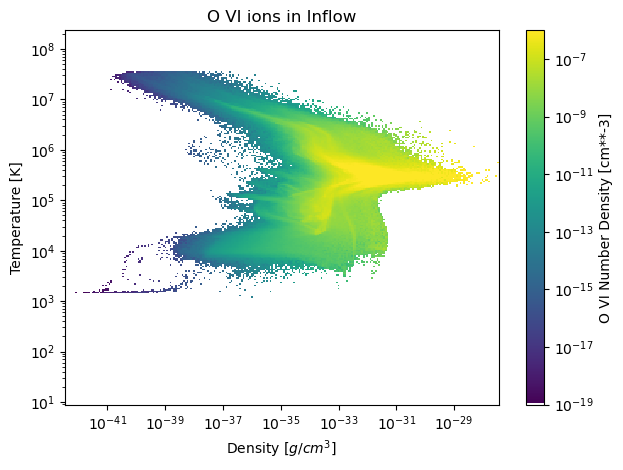

1.260470642945104e-23
Creating phase space plot for outflow


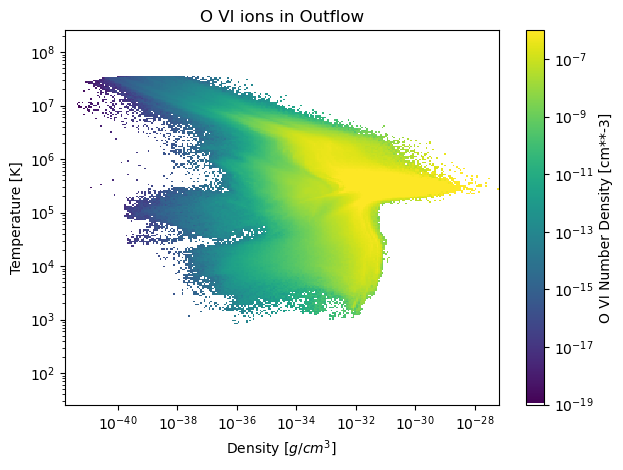

6.056748239163333e-23


In [21]:
# to save
prefix = output_dir+ '/' + 'ions_halo_00' + halo + '/' + run + '/' + '100' + '/'


ions = ['C IV','O VI']
#['C III','C IV','O VI','O II','O III','Ne III', 'Ne V', 'Fe II', 'Fe III']
density_fields = ['C_p3_density','O_p5_density'] 
#['C_p2_density','C_p3_density','O_p5_density','O_p1_density','O_p2_density','Ne_p2_density','Ne_p4_density','Fe_p1_density','Fe_p2_density'] 
numdensity_fields = ['C_p3_number_density','O_p5_number_density']
#['C_p2_number_density','C_p3_number_density','O_p5_number_density','O_p1_number_density','O_p2_number_density','Ne_p2_number_density','Ne_p4_number_density','Fe_p1_number_density','Fe_p2_number_density'] 


for ion_name, ion_density_field, ion_numdensity_field in zip(ions,density_fields,numdensity_fields):

    density_field = ('gas', f'{ion_density_field}')
    temperature_field = ('gas', 'temperature')
    target_field = ('gas', f'{ion_numdensity_field}')  # Field to plot (e.g., number density of C IV)

    print(ion_name, density_field,temperature_field,target_field)
    
    
    #Call the function to create the plot
    print('Creating phase space plot for all gas')
    create_phase_space_plot(refine_box, density_field, temperature_field, target_field, ion_name=ion_name, region = None)
    
    print('Creating phase space plot for inflow')
    create_phase_space_plot(box_inflow, density_field, temperature_field, target_field, ion_name=ion_name, region = 'Inflow')
    
    print('Creating phase space plot for outflow')
    create_phase_space_plot(box_outflow, density_field, temperature_field, target_field, ion_name=ion_name, region = 'Outflow')